In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
from sFLD import *
from calculate_error import *

# Get the Files Containing the Simulated Spectral Data

In [30]:
e_pathname = "/Users/jameswallace/Desktop/Project/data/verification_run_2021-06-14-1239/Esun.csv"
l_pathname = "/Users/jameswallace/Desktop/Project/data/verification_run_2021-06-14-1239/Lo_spectrum_inclF.csv"
f_pathname = "/Users/jameswallace/Desktop/Project/data/verification_run_2021-06-14-1239/fluorescence_scalars.csv"

In [31]:
# place the spectra in readable dataframes
e_df = get_simulated_spectral_df(e_pathname)
l_df = get_simulated_spectral_df(l_pathname)
f_df = pd.read_csv(f_pathname)
f_df = f_df.iloc[1:]

In [32]:
# get the O2A fluorescence from the fluorescence scalars df
f_761 = pd.to_numeric(f_df['F761'])

In [33]:
# now average them for every ten rows
e_average = average_dataframe(e_df, 10)
l_average = average_dataframe(l_df, 10)
f_average = average_dataframe(f_761, 10)

# Resample the E and L spectra to match retrieval instrument FWHM

In [34]:
# for each row in the dataframe resample the spectra

# get each row of spectra df
# re-sample at instrument wavelengths
# save arrays to new array

e_resampled = []

for row in e_average.index:
    temp = np.asarray(e_average.iloc[row])
    temp_resampled = resample_spectra(3.5, temp)[0]
    e_resampled.append(temp_resampled)
    
l_resampled = []

for row in l_average.index:
    temp = np.asarray(l_average.iloc[row])
    temp_resampled, re_wave = resample_spectra(3.5, temp)
    l_resampled.append(temp_resampled)

# generate two arrays containing the arrays of the resampled data

# Apply the sFLD method to each resampled averaged row in the E and L dfs

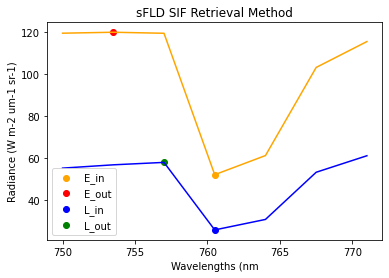

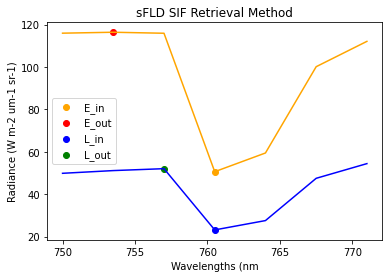

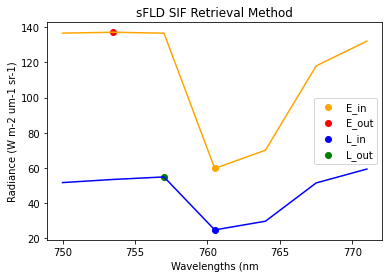

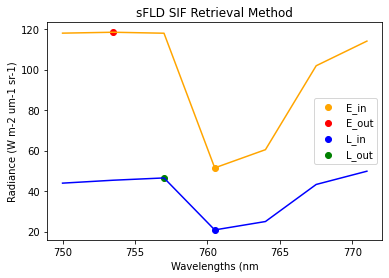

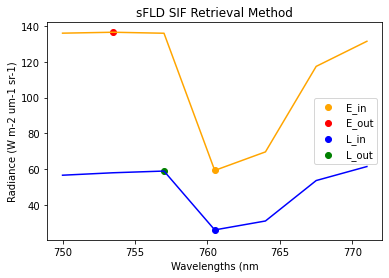

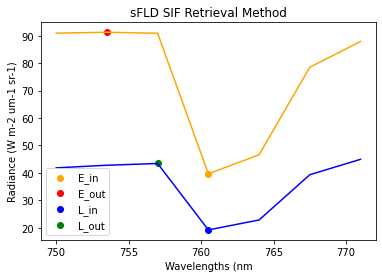

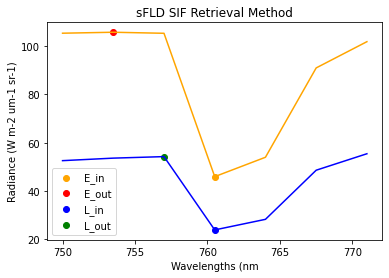

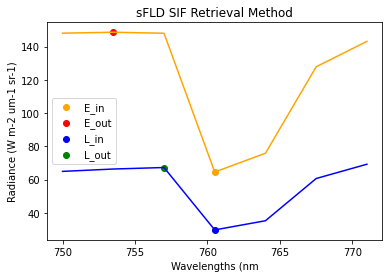

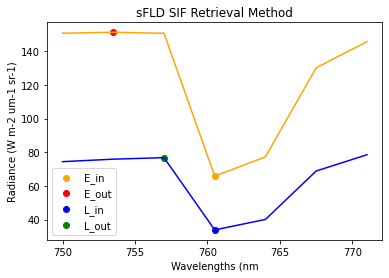

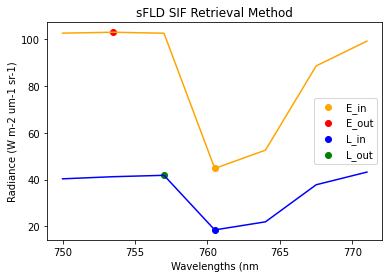

In [35]:
differences = []
percentage_errors = []
for i in range(len(e_resampled)):
    error = f_average[i] - sFLD(e_resampled[i], l_resampled[i], re_wave, plot = True)
    error = np.sqrt(error**2)
    differences.append(error)
    percentage_errors.append(100*(f_average[i] - error) / f_average[i])

In [36]:
np.mean(percentage_errors)

62.359010137186274

Average percentage error is 62.5% for the resampled data.

# Apply sFLD to averaged data

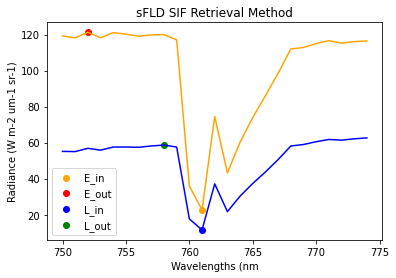

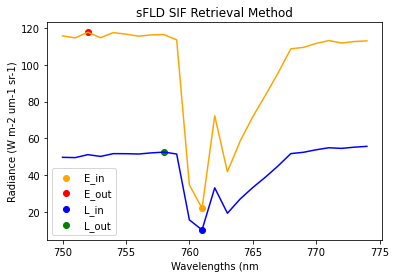

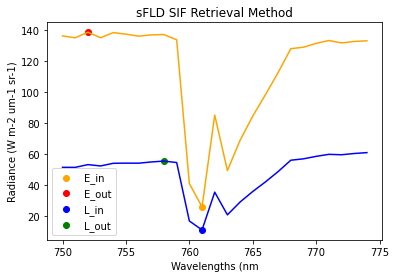

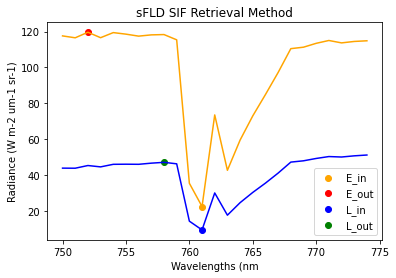

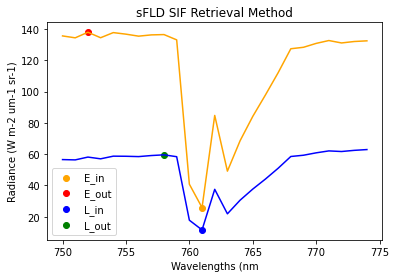

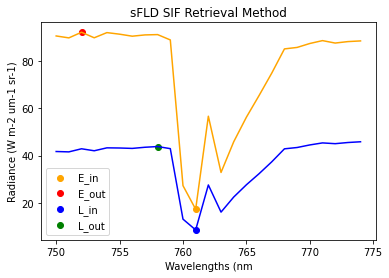

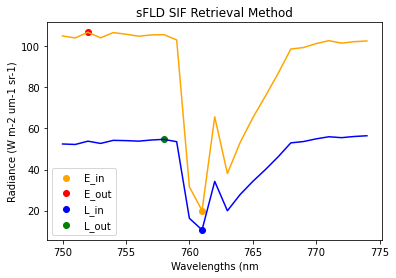

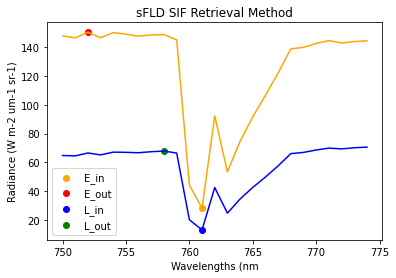

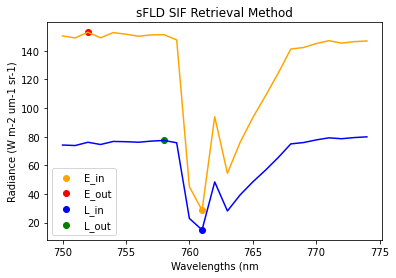

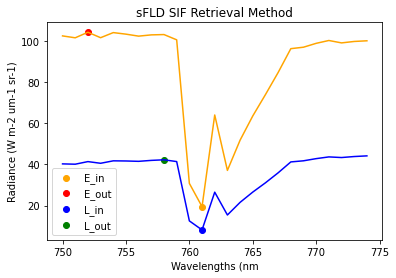

In [37]:
differences2 = []
percentage_errors2 = []
for i in range(len(e_average)):
    error = f_average[i] - sFLD(np.asarray(e_average.iloc[i]), np.asarray(l_average.iloc[i]), np.arange(400, 2562), plot = True)
    error = np.sqrt(error**2)
    differences2.append(error)
    percentage_errors2.append(100*(f_average[i] - error) / f_average[i])
    

In [38]:
np.mean(percentage_errors2)

84.61389649812865

Average percentage error is 84.6% for the original simulated data.

# Force $E_{out}$ and $L_{out}$ to take the same wavelength

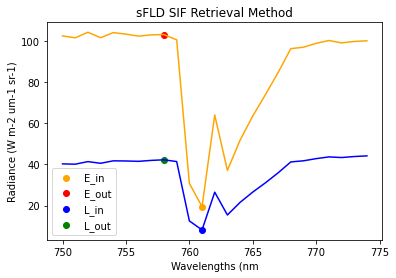

0.26147266384532175

In [39]:
# use the alt_sFLD method in the sFLD file

# forces E_out to have the same wavelength as L_out

alt_sFLD(np.asarray(e_average.iloc[i]), np.asarray(l_average.iloc[i]), np.arange(400, 2562), plot = True)

In [40]:
# now trial with original simulated data

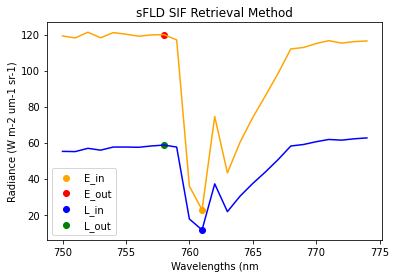

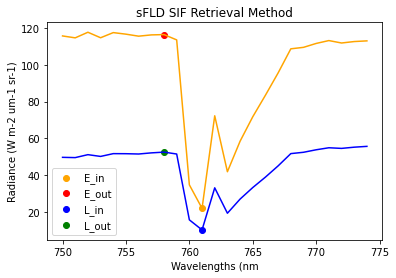

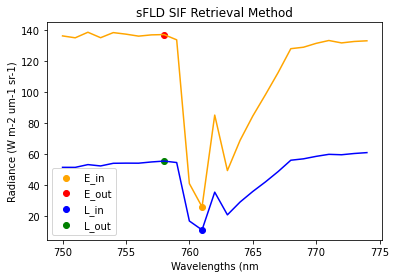

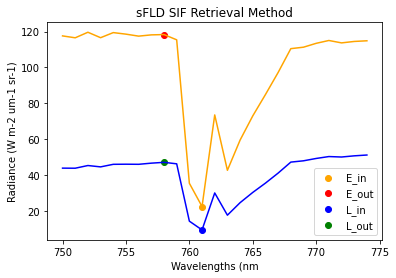

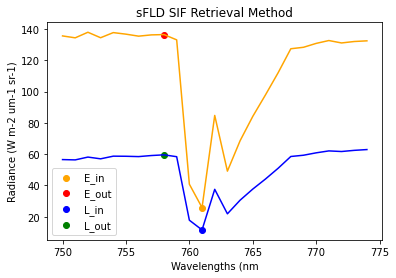

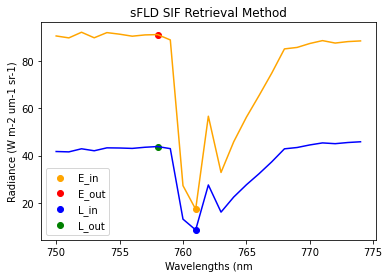

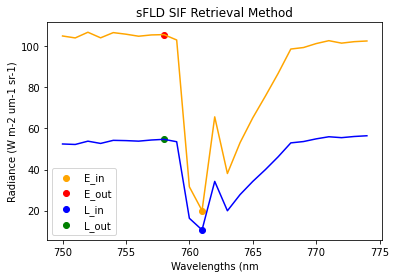

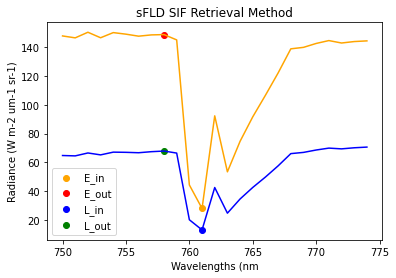

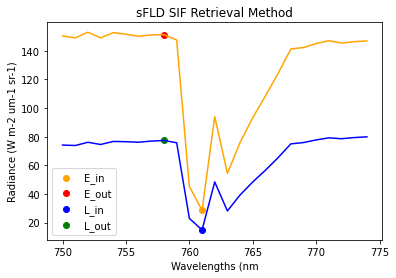

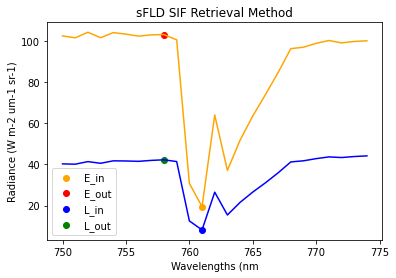

In [41]:
differences3 = []
percentage_errors3 = []
for i in range(len(e_average)):
    error = f_average[i] - alt_sFLD(np.asarray(e_average.iloc[i]), np.asarray(l_average.iloc[i]), np.arange(400, 2562), plot = True)
    error = np.sqrt(error**2)
    differences3.append(error)
    percentage_errors3.append(100*(f_average[i] - error) / f_average[i])
    

In [42]:
np.mean(percentage_errors3)

65.43140124770018

In [43]:
# now trial with re-sampled data

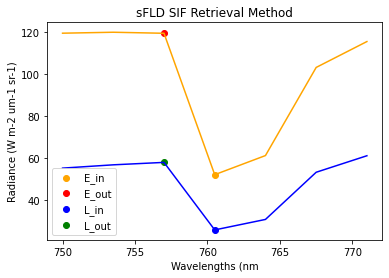

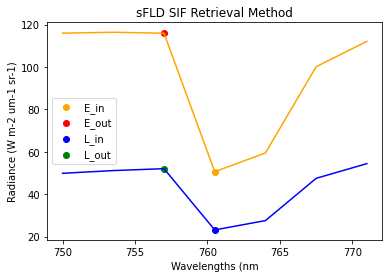

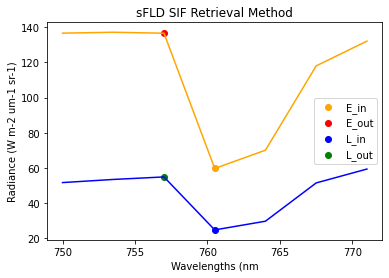

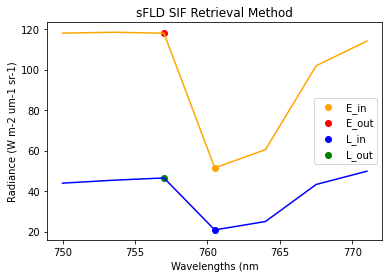

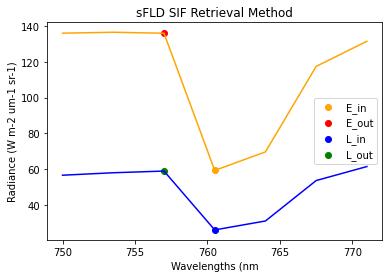

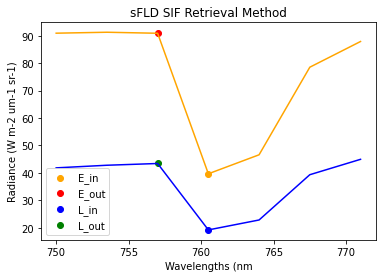

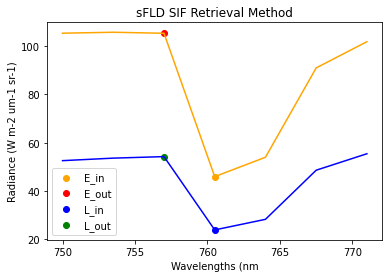

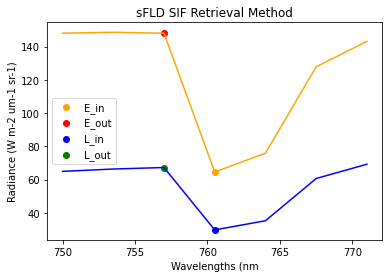

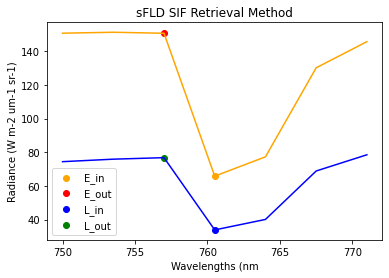

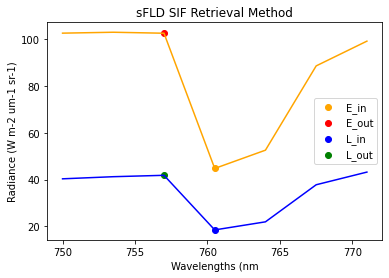

In [44]:
differences4 = []
percentage_errors4 = []
for i in range(len(e_resampled)):
    error = f_average[i] - alt_sFLD(e_resampled[i], l_resampled[i], re_wave, plot = True)
    error = np.sqrt(error**2)
    differences4.append(error)
    percentage_errors4.append(100*(f_average[i] - error) / f_average[i])

In [45]:
np.mean(percentage_errors4)

75.28603157142457

# Analysis

At 1 nm FWHM the sFLD works best when E_out and L_out are forced to have the same wavelength value. This yeilds a percentage error of approx. 65% of the SIF value retrieved at the O2A band.

At 3.5 nm the sFLD method works best when E_out is selected to have the largest value in the spectral range. This means that E_out is often selected further from the absorption well than L_out. This methods yeilds an average percentage error of approx. 62%.

Need to repeat this analysis with a larger dataset to validate algorithm error rates.


# Trial 3FLD method implementation

In [130]:
def three_FLD(e_spectra, l_spectra, wavelengths, plot, O2A_band = True):
    """Applies the 3FLD algorithm for SIF retrieval at either the O2A or O2B absorption band

    Parameters
    ----------
    e_spectra : np.array
        np array containing the downwelling irradiance values at the wavelengths provided
    l_spectra : np.array
        np array containing the upwelling radiance values at the wavelengths provided
    wavelengths : np.array
        np array containing the wavelengths at which the E and L spectra are sampled at
    plot: bool
        Determines whether plot of spectra and points choosen for sFLD will be shown
    O2A_band : bool, optional
        Determines if the target retrieval band is the O2A absorption band, by default True
        
    Outputs
    --------
    fluorescence: float
        Fluorescence at the O2A absorption band retrieved using the sFLD method
    """
    
    e_spectra = e_spectra / np.pi
    
    
    # O2A 760
    # O2B 687
    
    # look for index of value nearest 750, 775, 670 and 700
    e_o2a_left_index = find_nearest(wavelengths, 750)
    e_o2a_right_index = find_nearest(wavelengths, 775)
    l_o2a_left_index = find_nearest(wavelengths, 750)
    l_o2a_right_index = find_nearest(wavelengths, 775)
    
    e_o2b_left_index = find_nearest(wavelengths, 670)
    e_o2b_right_index = find_nearest(wavelengths, 700)
    l_o2b_left_index = find_nearest(wavelengths, 670)
    l_o2b_right_index = find_nearest(wavelengths, 700)
    
    
    
    
    # define spectral regions (index begins at 400 nm)
    if O2A_band == True:
        e_spectra_range = e_spectra[e_o2a_left_index:e_o2a_right_index]
        l_spectra_range = l_spectra[l_o2a_left_index:l_o2a_right_index]
    if O2A_band == False:
        e_spectra_range = e_spectra[e_o2b_left_index:e_o2b_right_index]
        l_spectra_range = l_spectra[l_o2b_left_index:l_o2b_right_index]
    
    # look for minima in spectral region
    
    e_argmin = np.argmin(e_spectra_range)
    l_argmin = np.argmin(l_spectra_range)
    
    
    # get this value for both
    
    e_in = e_spectra_range[e_argmin]
    l_in = l_spectra_range[l_argmin]
    
    
    # look to left of this region for shoulder maxima
    
    e_left_shoulder = e_spectra_range[:e_argmin]
    l_left_shoulder = l_spectra_range[:l_argmin]
    
    # look for maxima at left shoulder
    
    e_argmax_left = np.argmax(e_left_shoulder)
    l_argmax_left = np.argmax(l_left_shoulder)
    
    # get max from left shoulder
    e_out_left = e_left_shoulder[e_argmax_left]
    l_out_left = l_left_shoulder[l_argmax_left]
    
    # repeat for right shoulder
    
    e_right_shoulder = e_spectra_range[e_argmin:]
    l_right_shoulder = l_spectra_range[l_argmin:]
    
    # look for maxima at right shoulder
    
    e_argmax_r = np.argmax(e_right_shoulder)
    l_argmax_r = np.argmax(l_right_shoulder)
    
    # get max from right shoulder
    e_out_right = e_right_shoulder[e_argmax_r]
    l_out_right = l_right_shoulder[l_argmax_r]
    
    
    # interpolate between the shoulders
    
    # generate array of wavelength values between the two selected shoulders
    wavelengths_interpol = wavelengths[e_argmax_left + e_o2a_left_index - 1: e_argmax_r + e_o2a_left_index + 1 + e_argmin]
    
    # get equation of the line between the two shoulders
    xp = [wavelengths_interpol[0], wavelengths_interpol[-1]]
    fp = [e_out_left, e_out_right]

    coefficients = np.polyfit(xp, fp, 1) # run polyfit on linear model
    
    e_interpolated_value = wavelengths[e_argmin+e_o2a_left_index]*coefficients[0] + coefficients[1]
    
    # plot the linear interpolation
    plt.plot(wavelengths_interpol, wavelengths_interpol*coefficients[0] + coefficients[1], alpha = 0.6, label = '3FLD Interpolation')
    plt.scatter(wavelengths[e_argmin+e_o2a_left_index], wavelengths[e_argmin+e_o2a_left_index]*coefficients[0] + coefficients[1])
    
    
    # repeat for L spectra
    
    # generate array of wavelength values between the two selected shoulders
    wavelengths_interpol = wavelengths[l_argmax_left + l_o2a_left_index - 1: l_argmax_r + l_o2a_left_index + 1 + l_argmin]
    
    # get equation of the line between the two shoulders
    xp = [wavelengths_interpol[0], wavelengths_interpol[-1]]
    fp = [l_out_left, l_out_right]

    coefficients = np.polyfit(xp, fp, 1) # run polyfit on linear model
    
    l_interpolated_value = wavelengths[l_argmin+l_o2a_left_index]*coefficients[0] + coefficients[1]
    
    # plot the linear interpolation
    plt.plot(wavelengths_interpol, wavelengths_interpol*coefficients[0] + coefficients[1], alpha = 0.6, label = '3FLD Interpolation')
    plt.scatter(wavelengths[l_argmin+l_o2a_left_index], wavelengths[l_argmin+l_o2a_left_index]*coefficients[0] + coefficients[1])
    

    
    # calc flourescence
    
    e_out = e_interpolated_value
    l_out = l_interpolated_value
    
    fluorescence = (e_out*l_in - l_out*e_in) / (e_out - e_in)
    
    
    
    if plot == True:
        # plot points selected
        
        #plt.scatter(e_argmin + 750, e_in)
        plt.plot(wavelengths[e_o2a_left_index:e_o2a_right_index] ,e_spectra[e_o2a_left_index:e_o2a_right_index], color = 'orange')
        plt.plot(wavelengths[l_o2a_left_index:l_o2a_right_index] ,l_spectra[l_o2a_left_index:l_o2a_right_index], color = 'b')
        plt.scatter(wavelengths[e_argmin + e_o2a_left_index], e_in, color = 'orange', label = 'E_in')
        plt.scatter(wavelengths[e_argmax_left + e_o2a_left_index], e_out_left, color = 'red', label = 'E_out')
        plt.scatter(wavelengths[l_argmin + l_o2a_left_index], l_in, color = 'b', label = 'L_in')
        plt.scatter(wavelengths[l_argmax_left + l_o2a_left_index], l_out_left, color = 'green', label = 'L_out')
        plt.scatter(wavelengths[e_argmax_r + e_o2a_left_index + e_argmin], e_out_right, label = 'E_out_r')
        plt.scatter(wavelengths[l_argmax_r + l_o2a_left_index + l_argmin], l_out_right, label = 'L_out_r')
        plt.title('3FLD SIF Retrieval Method')
        plt.xlabel('Wavelengths (nm')
        plt.ylabel('Radiance (W m-2 um-1 sr-1)')
        plt.legend()
        plt.show()
    
    return(fluorescence)

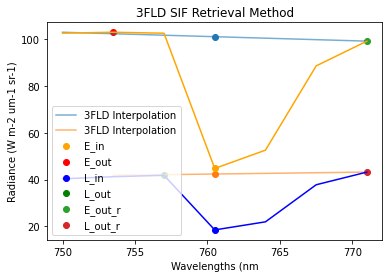

-0.4990100797789599

In [131]:
three_FLD(e_resampled[i], l_resampled[i], re_wave, plot = True)